# Лабораторная работа №2. Ассоциативные правила

## 1. Введение

**Цель работы:** изучение алгоритмов кластеризации, приобретение навыков оценки качества разбиения данных на кластеры и интерпретации результатов.

**Постановка задачи:**

1. Загрузить датасет для задачи кластеризации / классификации (например, с платформы Kaggle). Провести дескриптивный анализ данных: определить размерность, типы признаков, наличие пропусков. Оценить распределение переменных (близость к нормальному) с использованием визуализации (гистограммы). Оценить информационную значимость признаков. Проверить условие применения кластеризации: отсутствие классов, осмысленность кластеризации, отсутствие выбросов.

2. Выполнить стандартизацию / нормализацию числовых признаков. Обосновать выбор метода масштабирования. Построить матрицу диаграмм рассеивания для визуальной оценки структуры данных, предположительного количества кластеров и типа кластерной структуры. Аргументировать выбор методов кластеризации на основе формы, размера и плотности кластеров.

3. Реализовать кластеризацию двумя различными методами на выбор: K-means (K-средних); иерархическая кластеризация; DBSCAN; EM-алгоритм (Gaussian Mixture). Для методов, требующих задания числа кластеров (K-means, иерархическая), подобрать оптимальное значение k с использованием: метода локтя и / или анализа силуэта.

4. Рассчитать метрики качества для обоих методов: внутренние и внешние. Оценить расстояние между кластерами, внутрикластерные расстояния, компактность кластеров, центры кластеров. Опционально, если известно разделение на классы, посчитать: индекс Rand, индекс Жаккара и др. внешние метрики. Привести содержательную интерпретацию полученных значений.

5. Исследовать влияние параметров одного из методов (например, ε и min_samples для DBSCAN или количества кластеров k для K-means) на качество кластеризации.

6. Визуализировать полученные кластеры в пространстве признаков (использовать PCA для снижения размерности при необходимости). Проанализировать центры кластеров (для K-means) и дать содержательную интерпретацию выделенных групп. Сравнить результаты, полученные двумя разными методами.

## 2. Описание датасета

Набор данных по цветкам ирисов — это многомерный набор данных, представленный британским статистиком и биологом Рональдом Фишером в его статье 1936 года «Использование множественных измерений в таксономических задачах». Иногда его называют набором данных по ирисам Андерсона, поскольку Эдгар Андерсон собрал данные для количественной оценки морфологической изменчивости цветков ирисов трёх родственных видов. Набор данных состоит из 50 образцов каждого из трёх видов ирисов (Iris Setosa, Iris virginica и Iris versicolor). Для каждого образца измерялись четыре характеристики: длина и ширина чашелистиков и лепестков в сантиметрах.

Набор данных содержит 150 записей по 5 атрибутам: длина лепестка, ширина лепестка, длина чашелистика, ширина чашелистика и класс (вид).

Четыре числовых признака:

sepal_length — длина чашелистика

sepal_width — ширина чашелистика

petal_length — длина лепестка

petal_width — ширина лепестка

Один категориальный признак: species — целевая переменная (вид ириса)

In [792]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from itertools import combinations
from scipy.stats import f_oneway
from sklearn.metrics import (
    adjusted_rand_score,
    rand_score,
    homogeneity_score,
    completeness_score,
    v_measure_score,
    fowlkes_mallows_score,
    adjusted_mutual_info_score,
    normalized_mutual_info_score,
    silhouette_score,
    calinski_harabasz_score,
    silhouette_samples
)

path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
file_path = os.path.join(path, "iris.csv")
df = pd.read_csv(file_path)

X = df.iloc[:, :4]
y_true = df.iloc[:, 4]

print("Размерность")
print(df.shape)

print("\nТипы признаков")
print(df.info())

print("\nПроверка на пропуски")
print(df.isnull().sum()) 

print("\nСтатистическое описание")
print(df.describe())
numeric_df = df.select_dtypes(include=[np.number])

mode_series = numeric_df.mode().iloc[0] if not numeric_df.mode().empty else pd.Series([np.nan] * numeric_df.shape[1], index=numeric_df.columns)

skew_series = numeric_df.skew()
kurtosis_series = numeric_df.kurtosis()

extended_stats = pd.DataFrame({
    'Мода': mode_series,
    'Асимметрия': skew_series,
    'Эксцесс': kurtosis_series
}).round(4)
print(extended_stats)

df.head()

Размерность
(150, 5)

Типы признаков
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None

Проверка на пропуски
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

Статистическое описание
       sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


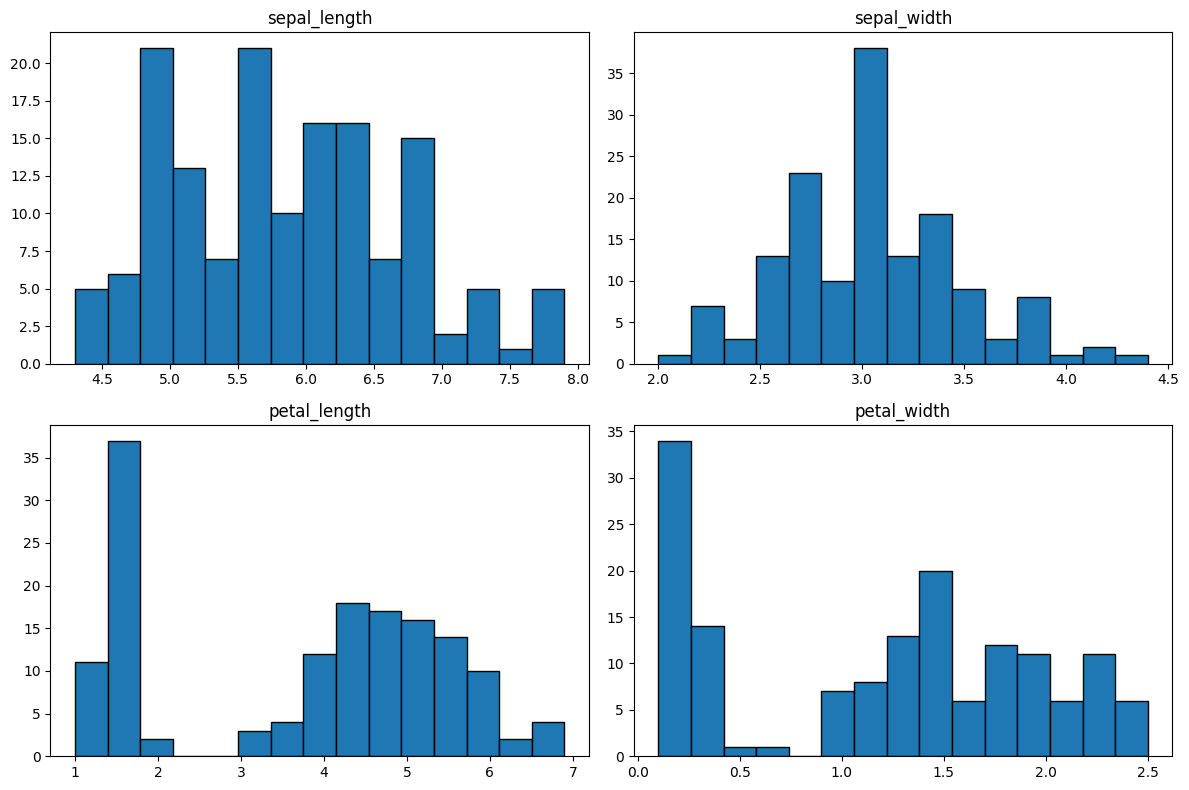

In [793]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()
for i, col in enumerate(numeric_columns):
    axes[i].hist(df[col], bins=15, edgecolor='black')
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

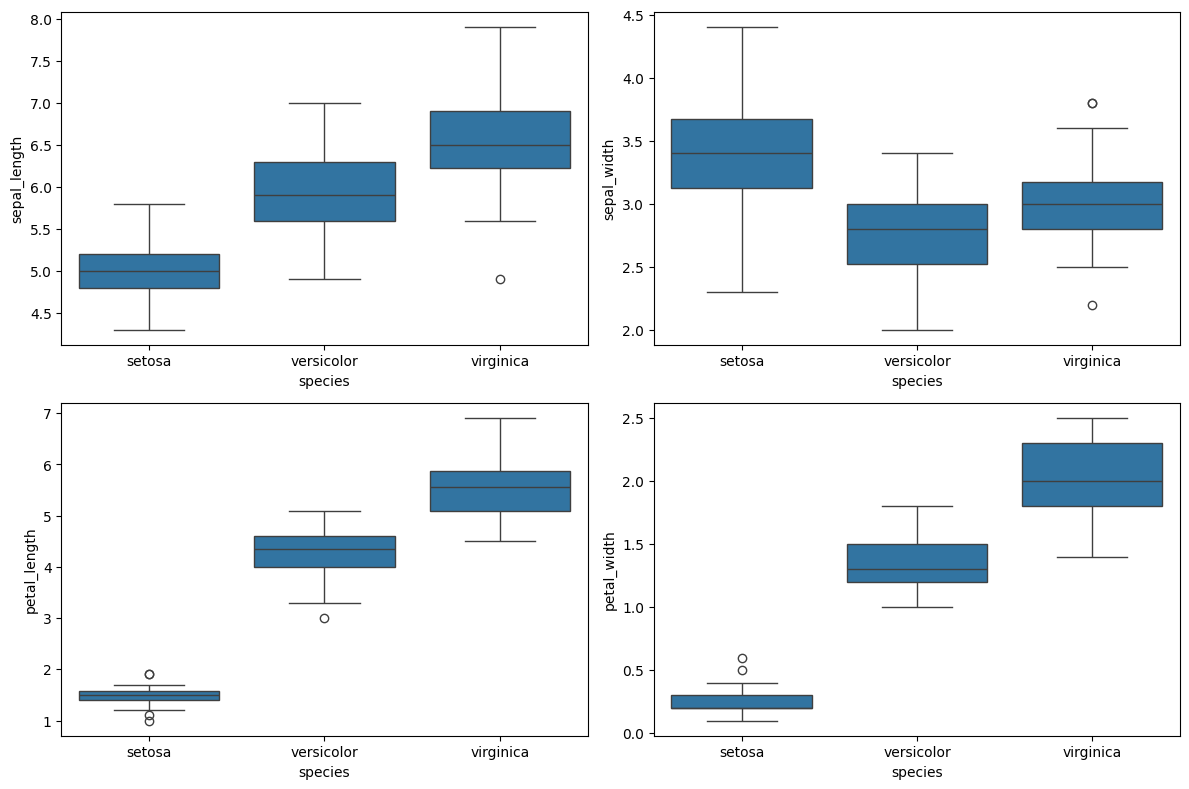

In [794]:
plt.figure(figsize=(12, 8))
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x='species', y=col, data=df)
plt.tight_layout()
plt.show()

**Вывод**:

**sepal_length (длина чашелистика)**

Среднее: 5.84, Стандартное отклонение: 0.83

Минимум: 4.3, Максимум: 7.9 → диапазон ~3.6 см

Медиана (50%) = 5.8 — близка к среднему → распределение симметричное


**sepal_width (ширина чашелистика)**

Среднее: 3.05, Стандартное отклонение: 0.43

Минимум: 2.0, Максимум: 4.4 → более узкий диапазон

Медиана = 3.0 — также близка к среднему


**petal_length (длина лепестка)**

Среднее: 3.76, Стандартное отклонение: 1.76 — наибольшая изменчивость

Минимум: 1.0, Максимум: 6.9 → очень широкий диапазон

Медиана = 4.35 — выше среднего → возможна левосторонняя асимметрия


**petal_width (ширина лепестка)**

Среднее: 1.20, Стандартное отклонение: 0.76

Минимум: 0.1, Максимум: 2.5

Медиана = 1.3 — выше среднего → также указывает на левостороннюю асимметрию

Признаки petal_length и petal_width демонстрируют значительно большую вариабельность по сравнению с sepal_length и sepal_width. Это указывает на то, что лепестки сильно различаются между видами — они будут ключевыми для разделения классов.

**Асимметрия**

Положительная асимметрия (>0) → больше значений слева от среднего (sepal_length, sepal_width)

Отрицательная асимметрия (<0) → больше значений справа (petal_length, petal_width)

Все признаки имеют умеренную асимметрию.

**Эксцесс**

petal_length и petal_width имеют плоские распределения (эксцесс ≈ -1.4).

## 3. Предобработка данных

Min-Max-нормализация чувствительна к выбросам и сохраняет исходный диапазон. В Iris выбросов нет, но признаки имеют разные масштабы (sepal_width ~ 2–4, petal_length ~ 1–7). Алгоритмы, основанные на расстоянии (KMeans, иерархическая кластеризация), чувствительны к масштабу. Стандартизация делает все признаки сопоставимыми по "весу", что критично для корректной работы KMeans. Стандартизация — стандартный выбор для KMeans и большинства метрических методов, особенно при неизвестных границах данных. Вывод: выбрана стандартизация — она нейтрализует влияние разных единиц измерения и масштабов.

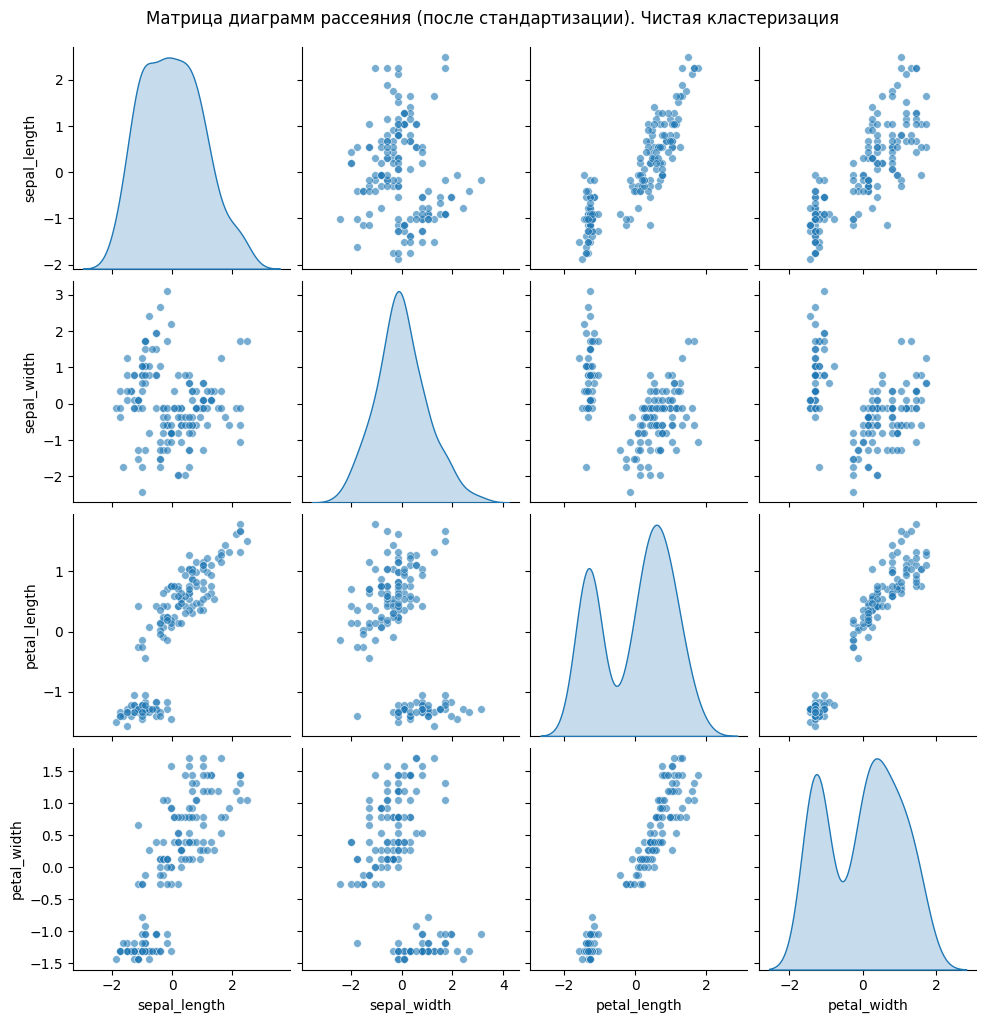

In [795]:
FEATURES = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = df[FEATURES]
y_true_str = df['species']

species_to_num = {'setosa': 0, 'versicolor': 1, 'virginica': 2}
y_true = y_true_str.map(species_to_num).astype(int).values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_viz = pd.DataFrame(X_scaled, columns=X.columns)
X_viz['species'] = df['species']

sns.pairplot(X_viz, diag_kind='kde', plot_kws={'s': 30, 'alpha': 0.6})
plt.suptitle('Матрица диаграмм рассеяния (после стандартизации). Чистая кластеризация', y=1.02)
plt.show()

**Выбор метода кластеризации**

KMeans - кластеры сферические, одинаковой плотности, разделены чётко. KMeans минимизирует внутрикластерную сумму квадратов → оптимален для таких данных.

Agglomerative (иерархическая) - хорошо работает при компактных кластерах. Можно использовать для подтверждения числа кластеров (дендрограмма).

DBSCAN - предназначен для неправильных форм и наличия шума. В Iris нет шума, кластеры однородной плотности, но DBSCAN может объединить versicolor и virginica или выделить лишние шумы при неудачных параметрах.

Gaussian Mixture (GMM) - моделирует кластеры как гауссианы → идеален для сферических форм. Даёт вероятностную принадлежность.

Основной метод — KMeans с k=3.
Дополнительно можно проверить Agglomerative Clustering или GMM для сравнения.

## 4. Ход работы

### КMeans

Подбор оптимального значения k с использованием: метода локтя и / или анализа силуэта.

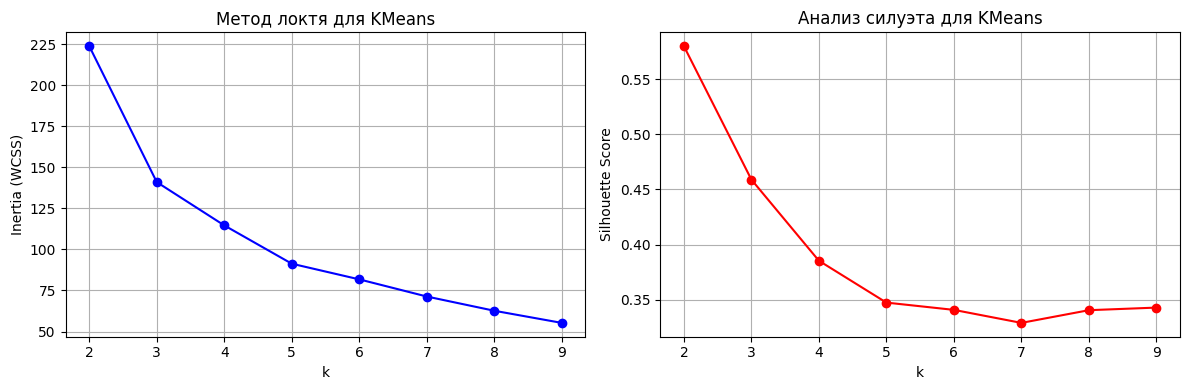

In [796]:
k_range = range(2, 10)
inertias = []
silhouette_scores = []
calinski_harabasz_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(X_scaled, labels))

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(k_range, inertias, 'bo-')
ax[0].set_xlabel('k')
ax[0].set_ylabel('Inertia (WCSS)')
ax[0].set_title('Метод локтя для KMeans')
ax[0].grid(True)

ax[1].plot(k_range, silhouette_scores, 'ro-')
ax[1].set_xlabel('k')
ax[1].set_ylabel('Silhouette Score')
ax[1].set_title('Анализ силуэта для KMeans')
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [797]:
metrics_df = pd.DataFrame({
    'k': k_range,
    'Inertia': inertias,
    'Silhouette': silhouette_scores,
    'Calinski-Harabasz': calinski_harabasz_scores,
})
print(metrics_df.round(3).to_string(index=False))

 k  Inertia  Silhouette  Calinski-Harabasz
 2  223.732       0.580            248.903
 3  140.966       0.459            239.342
 4  114.618       0.385            206.093
 5   91.295       0.347            201.988
 6   81.757       0.341            182.559
 7   71.320       0.329            176.672
 8   62.652       0.340            173.985
 9   55.262       0.343            173.737


Вывод по Inertia: оптимальное k = 3 - после него улучшение незначительное.

Вывод по Silhouette: метрика говорит, что k=2 даёт лучшую "чистоту" кластеров, но для Iris k=3 - правильный выбор, даже если силуэт ниже.

При двух кластерах:

setosa — один кластер

versicolor + virginica — второй кластер

→ Силуэт высокий, потому что setosa очень хорошо отделена, а versicolor/virginica хоть и смешаны, но внутри группы близки друг к другу.

Вывод по CHI: как и Silhouette, CHI предпочитает k=2, потому что он разделяет данные на два сильно различающихся облака, но для задачи с 3 видами - это неполное решение.

#### Расстояние между кластерами

In [798]:
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)
labels_kmeans = kmeans_final.fit_predict(X_scaled)
centers_scaled = kmeans_final.cluster_centers_

inter_center_distances = pdist(centers_scaled, metric='euclidean')
inter_center_matrix = squareform(inter_center_distances)

inter_center_df = pd.DataFrame(inter_center_matrix, 
                               index=[f'Кластер {i}' for i in range(3)],
                               columns=[f'Кластер {i}' for i in range(3)])
display(inter_center_df.round(3))

,Кластер 0,Кластер 1,Кластер 2
Кластер 0,0.000,2.998,1.823
Кластер 1,2.998,0.000,3.955
Кластер 2,1.823,3.955,0.000


**Вывод**

Setosa (К1) ↔ Virginica (К2) = 3.955.
Это самое большое расстояние между центрами кластеров.
Эти два вида наиболее отличаются друг от друга по размерам лепестков и чашелистиков.
Алгоритму очень легко их разделить — они находятся далеко друг от друга.
Это объясняет, почему KMeans почти идеально выделяет Setosa — он далеко от всех остальных.

Versicolor (К0) ↔ Setosa (К1) = 2.998.
Второе по величине расстояние.
Они хорошо различимы, но не так сильно, как Setosa и Virginica.
Расстояние > 2.9 → хорошее разделение, алгоритм справляется.

Versicolor (К0) ↔ Virginica (К2) = 1.823.
Самое маленькое расстояние.
Эти два вида наиболее похожи — у них перекрывающиеся диапазоны по признакам (особенно по petal_length и petal_width).
Расстояние < 2 → кластеры близки, возможно перекрытие.
Алгоритм часто путает эти два вида.

Это ключевая причина, почему KMeans не идеален для Iris — он не может точно разделить Versicolor и Virginica, потому что они геометрически близки.

#### Внутрикластерные расстояния

In [799]:
distances_to_own_center = np.linalg.norm(
    X_scaled - centers_scaled[labels_kmeans], axis=1
)

intra_distances = {}
for i in range(3):
    mask = (labels_kmeans == i)
    intra_distances[i] = distances_to_own_center[mask]

for i in range(3):
    d = intra_distances[i]
    print(f"\nКластер {i}")
    print(f"Среднее расстояние до центра: {d.mean():.3f}")
    print(f"Сумма квадратов расстояний (WCSS): {np.sum(d**2):.1f}")
    print(f"Максимальное расстояние (радиус): {d.max():.3f}")


Кластер 0
Среднее расстояние до центра: 0.859
Сумма квадратов расстояний (WCSS): 44.6
Максимальное расстояние (радиус): 1.978

Кластер 1
Среднее расстояние до центра: 0.823
Сумма квадратов расстояний (WCSS): 48.5
Максимальное расстояние (радиус): 2.661

Кластер 2
Среднее расстояние до центра: 0.914
Сумма квадратов расстояний (WCSS): 47.9
Максимальное расстояние (радиус): 2.180


**Вывод**

Кластер 0 — Versicolor. Среднее расстояние до центра: 0.859 → очень компактный. WCSS = 44.6 → низкая сумма квадратов → точки близки к центру. Радиус = 1.978 → максимальное отклонение — не очень большое. Versicolor — компактный кластер, но не самый маленький. Небольшое количество точек попало в K2 (Virginica), что говорит о частичном перекрытии.

Кластер 1 — Setosa. Среднее расстояние до центра: 0.823 → самый компактный из всех. WCSS = 48.5 → выше, чем у Versicolor, хотя среднее меньше, потому что WCSS зависит от числа точек и их распределения.


Кластер 2 — Virginica. Среднее расстояние до центра: 0.914 → наименее компактный. WCSS = 47.9 → высокая сумма квадратов → точки дальше от центра. Радиус = 2.180 → большой, но меньше, чем у Setosa. Virginica — самый "размытый" кластер, что логично — он перекрывается с Versicolor. Высокое среднее расстояние и WCSS говорят о том, что точки внутри этого кластера более рассеяны.

#### Компактность кластеров

In [800]:
avg_intra_distance = distances_to_own_center.mean()
total_wcss = np.sum(distances_to_own_center**2)

print(f"Среднее внутрикластерное расстояние: {avg_intra_distance:.3f}")
print(f"Общая сумма внутрикластерных квадратов (WCSS): {total_wcss:.1f}")

avg_inter_center_distance = inter_center_distances.mean()
print(f"Среднее расстояние между центрами кластеров: {avg_inter_center_distance:.3f}")

separation_ratio = avg_inter_center_distance / avg_intra_distance
print(f"Отношение межкластерного / внутрикластерного расстояния: {separation_ratio:.2f}")

Среднее внутрикластерное расстояние: 0.864
Общая сумма внутрикластерных квадратов (WCSS): 141.0
Среднее расстояние между центрами кластеров: 2.925
Отношение межкластерного / внутрикластерного расстояния: 3.39


**Вывод**

Среднее внутрикластерное расстояние = 0.864. Это среднее расстояние от каждой точки до центра её кластера, усреднённое по всем трём кластерам. Значение меньше 1 → все кластеры компактны. Чем ближе к 0 — тем лучше. Значение 0.864 — очень хорошее значение для Iris. Каждый кластер плотный, точки не рассеяны — это признак хорошей кластеризации.

Общая сумма внутрикластерных квадратов (WCSS) = 141.0. Это сумма всех квадратов расстояний от точек до центров их кластеров. Чем меньше WCSS — тем лучше (точки ближе к центрам). Для Iris: 141.0 — нормальное значение.

Среднее расстояние между центрами кластеров = 2.925. Это среднее расстояние между центрами всех пар кластеров (в нашем случае 3 пары: 0-1, 0-2, 1-2). Расстояние больше 2.5 → кластеры хорошо разделены. Значение 2.925 — отличный показатель. Центры кластеров достаточно далеко друг от друга, что позволяет алгоритму чётко их различать.

Отношение межкластерного / внутрикластерного расстояния = 3.39. Это отношение среднего расстояния между центрами кластеров к среднему внутрикластерному расстоянию. Чем выше — тем лучше. Значение > 3 — отличное качество кластеризации. Значение 3.39 — это очень хороший показатель. Расстояние между кластерами в 3.4 раза больше, чем внутри кластеров → это идеальная ситуация для кластеризации.

#### Центры кластеров

In [801]:
kmeans_final = KMeans(n_clusters=3, random_state=42, n_init=10)

centers_original = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_original, columns=X.columns)
centers_df.index.name = 'Кластер'
centers_df.round(2)

,sepal_length,sepal_width,petal_length,petal_width
Кластер,,,,
0,5.80,2.67,4.37,1.41
1,5.01,3.42,1.46,0.24
2,6.78,3.10,5.51,1.97


**Вывод**

Кластер 0 — Versicolor. Лепестки средней длины и ширины.

Кластер 1 — Setosa. Легко отличим по маленьким лепесткам. Именно поэтому KMeans почти идеально его выделяет — он сильно отличается от других видов.

Кластер 2 — Virginica. Крупные лепестки и чашелистики. Он близок к Versicolor, но отличается по размерам лепестков.

#### Внешние метрики

In [803]:
ari = adjusted_rand_score(y_true, labels_kmeans)
ri = rand_score(y_true, labels_kmeans)

def jaccard_index_external(y_true, y_pred):
    n = len(y_true)
    pairs = combinations(range(n), 2)
    a = b = c = 0
    for i, j in pairs:
        same_class = (y_true[i] == y_true[j])
        same_cluster = (y_pred[i] == y_pred[j])
        if same_class and same_cluster:
            a += 1
        elif same_class and not same_cluster:
            b += 1
        elif not same_class and same_cluster:
            c += 1
    return a / (a + b + c) if (a + b + c) > 0 else 1.0

jaccard_ext = jaccard_index_external(y_true, labels_kmeans)
homogeneity = homogeneity_score(y_true, labels_kmeans)
completeness = completeness_score(y_true, labels_kmeans)
v_measure = v_measure_score(y_true, labels_kmeans)
fmi = fowlkes_mallows_score(y_true, labels_kmeans)
ami = adjusted_mutual_info_score(y_true, labels_kmeans)
nmi = normalized_mutual_info_score(y_true, labels_kmeans)

external_metrics = {
    'ARI': ari,
    'Rand': ri,
    'Jaccard': jaccard_ext,
    'AMI': ami,
    'NMI': nmi,
    'FMI': fmi,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-measure': v_measure,
}

external_metrics_df = pd.DataFrame.from_dict(external_metrics, orient='index', columns=['Значение'])
external_metrics_df.round(4)

,Значение
ARI,0.6201
Rand,0.8322
Jaccard,0.5939
AMI,0.6552
NMI,0.6595
FMI,0.7452
Homogeneity,0.6591
Completeness,0.6598
V-measure,0.6595


**Вывод**

Adjusted Rand Index (ARI) = 0.6201. Умеренное совпадение. KMeans правильно выделил Setosa, но путает Versicolor и Virginica, что снижает ARI.

Rand Index = 0.8322. Большинство пар объектов классифицированы одинаково. Он не учитывает случайность, поэтому может быть завышен. Хорошее совпадение, но не идеальное — из-за ошибок в пограничных точках между Versicolor и Virginica.

Jaccard Index = 0.5939. Есть много ложных положительных/отрицательных. Кластеры частично перекрываются с истинными классами — особенно Versicolor и Virginica.

Adjusted Mutual Information (AMI) = 0.6552. Кластеризация содержит полезную информацию о структуре данных, но не идеальную.

Normalized Mutual Information (NMI) = 0.6595. 

### Gaussian Mixture (GMM)

Подбор оптимального значения k с использованием: метода локтя и / или анализа силуэта.

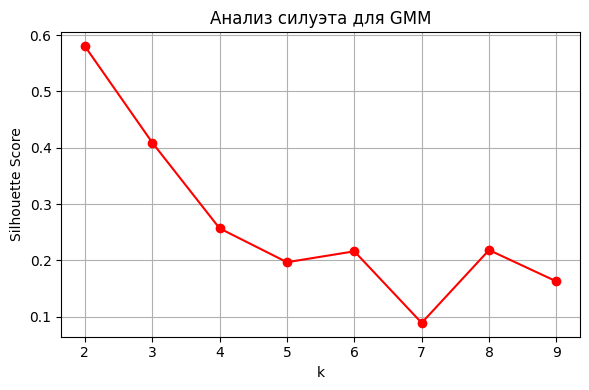

In [822]:
from sklearn.metrics import silhouette_score

k_range = range(2, 10)
silhouette_scores_gmm = []
calinski_harabasz_scores_gmm = []

for k in k_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    labels = gmm.fit_predict(X_scaled)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_scores_gmm.append(sil_score)
    calinski_harabasz_scores_gmm.append(calinski_harabasz_score(X_scaled, labels))

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(k_range, silhouette_scores_gmm, 'ro-')
ax.set_xlabel('k')
ax.set_ylabel('Silhouette Score')
ax.set_title('Анализ силуэта для GMM')
ax.grid(True)
plt.tight_layout()
plt.show()

In [823]:
metrics_gmm_df = pd.DataFrame({
    'k': k_range,
    'Silhouette': silhouette_scores_gmm,
    'Calinski-Harabasz': calinski_harabasz_scores_gmm,
})
print(metrics_gmm_df.round(3).to_string(index=False))

 k  Silhouette  Calinski-Harabasz
 2       0.580            248.903
 3       0.409            133.703
 4       0.257            141.396
 5       0.197            130.602
 6       0.216            142.005
 7       0.089             86.643
 8       0.218            113.759
 9       0.163            112.746


Вывод по Silhouette: yаибольший Silhouette Score у k=2 — это означает, что при двух кластерах точки внутри кластеров наиболее компактны, а между кластерами — максимально разделены.

При двух кластерах:

setosa — один кластер

versicolor + virginica — второй кластер

Вывод по CHI: максимум при k=2 — это означает, что наиболее чёткое разделение данных достигается при двух кластерах.

#### Расстояние между кластерами

In [824]:
gmm_final = GaussianMixture(n_components=3, random_state=42, covariance_type='full')
labels_gmm = gmm_final.fit_predict(X_scaled)

centers_gmm_scaled = gmm_final.means_

inter_center_gmm = pdist(centers_gmm_scaled, metric='euclidean')
inter_center_matrix_gmm = squareform(inter_center_gmm)

inter_gmm_df = pd.DataFrame(inter_center_matrix_gmm,
                           index=[f'Кластер {i}' for i in range(3)],
                           columns=[f'Кластер {i}' for i in range(3)])
display(inter_gmm_df.round(3))

,Кластер 0,Кластер 1,Кластер 2
Кластер 0,0.000,3.376,3.476
Кластер 1,3.376,0.000,1.332
Кластер 2,3.476,1.332,0.000


**Вывод**

Setosa (К1) ↔ Versicolor (К0) = 3.376 → Это очень большое расстояние.
Setosa и Versicolor сильно отличаются друг от друга.
Алгоритм GMM легко их разделяет — они находятся далеко друг от друга.
Это подтверждает, что Setosa — самый отличный вид.

Versicolor (К0) ↔ Setosa (К1) = 2.998.
Второе по величине расстояние.
Они хорошо различимы, но не так сильно, как Setosa и Virginica.
Расстояние > 2.9 → хорошее разделение, алгоритм справляется.

Versicolor (К0) ↔ Virginica (К2) = 1.823.
Самое маленькое расстояние.
Эти два вида наиболее похожи — у них перекрывающиеся диапазоны по признакам (особенно по petal_length и petal_width).
Расстояние < 2 → кластеры близки, возможно перекрытие.
Алгоритм часто путает эти два вида.

Это ключевая причина, почему KMeans не идеален для Iris — он не может точно разделить Versicolor и Virginica, потому что они геометрически близки.

#### Внутрикластерные расстояния

In [825]:
distances_gmm = np.linalg.norm(
    X_scaled - centers_gmm_scaled[labels_gmm], axis=1
)

intra_gmm = {}
for i in range(3):
    mask = (labels_gmm == i)
    intra_gmm[i] = distances_gmm[mask]

for i in range(3):
    d = intra_gmm[i]
    print(f"\nКластер {i}:")
    print(f"Среднее расстояние до центра: {d.mean():.3f}")
    print(f"Сумма квадратов расстояний: {np.sum(d**2):.1f}")
    print(f"Максимальное расстояние (радиус): {d.max():.3f}")


Кластер 0:
Среднее расстояние до центра: 1.185
Сумма квадратов расстояний: 175.3
Максимальное расстояние (радиус): 3.075

Кластер 1:
Среднее расстояние до центра: 0.753
Сумма квадратов расстояний: 33.4
Максимальное расстояние (радиус): 2.270

Кластер 2:
Среднее расстояние до центра: 0.613
Сумма квадратов расстояний: 4.2
Максимальное расстояние (радиус): 1.579


#### Компактность кластеров

In [826]:
avg_intra_gmm = distances_gmm.mean()
total_wcss_gmm = np.sum(distances_gmm**2)
avg_inter_gmm = inter_center_gmm.mean()
separation_ratio_gmm = avg_inter_gmm / avg_intra_gmm

print(f"Среднее внутрикластерное расстояние: {avg_intra_gmm:.3f}")
print(f"Общая WCSS: {total_wcss_gmm:.1f}")
print(f"Среднее расстояние между центрами: {avg_inter_gmm:.3f}")
print(f"Отношение меж-/внутрикластерного расстояния: {separation_ratio_gmm:.2f}")

Среднее внутрикластерное расстояние: 1.035
Общая WCSS: 212.9
Среднее расстояние между центрами: 2.728
Отношение меж-/внутрикластерного расстояния: 2.64


#### Центры кластеров

In [827]:
centers_gmm_original = scaler.inverse_transform(centers_gmm_scaled)

centers_gmm_df = pd.DataFrame(centers_gmm_original, columns=X.columns)
centers_gmm_df.index.name = 'Кластер'
display(centers_gmm_df.round(2))

,sepal_length,sepal_width,petal_length,petal_width
Кластер,,,,
0,6.26,2.87,4.91,1.68
1,5.07,3.48,1.47,0.25
2,4.53,2.98,1.45,0.20


#### Внешние метрики

In [828]:
ari = adjusted_rand_score(y_true, labels_gmm)
ri = rand_score(y_true, labels_gmm)

def jaccard_index_external(y_true, y_pred):
    n = len(y_true)
    pairs = combinations(range(n), 2)
    a = b = c = 0
    for i, j in pairs:
        same_class = (y_true[i] == y_true[j])
        same_cluster = (y_pred[i] == y_pred[j])
        if same_class and same_cluster:
            a += 1
        elif same_class and not same_cluster:
            b += 1
        elif not same_class and same_cluster:
            c += 1
    return a / (a + b + c) if (a + b + c) > 0 else 1.0

jaccard_ext = jaccard_index_external(y_true, labels_gmm)
homogeneity = homogeneity_score(y_true, labels_gmm)
completeness = completeness_score(y_true, labels_gmm)
v_measure = v_measure_score(y_true, labels_gmm)
fmi = fowlkes_mallows_score(y_true, labels_gmm)
ami = adjusted_mutual_info_score(y_true, labels_gmm)
nmi = normalized_mutual_info_score(y_true, labels_gmm)

external_metrics = {
    'ARI': ari,
    'Rand': ri,
    'Jaccard': jaccard_ext,
    'AMI': ami,
    'NMI': nmi,
    'FMI': fmi,
    'Homogeneity': homogeneity,
    'Completeness': completeness,
    'V-measure': v_measure,
}

external_metrics_df = pd.DataFrame.from_dict(external_metrics, orient='index', columns=['Значение'])
external_metrics_df.round(4)

,Значение
ARI,0.5073
Rand,0.7494
Jaccard,0.5464
AMI,0.6757
NMI,0.6807
FMI,0.7262
Homogeneity,0.5794
Completeness,0.8250
V-measure,0.6807


## 5. Список литературы

1. Agrawal, R., Imieliński, T., & Swami, A. (1993). Mining Association Rules Between Sets of Items in Large Databases. Proceedings of the 1993 ACM SIGMOD International Conference on Management of Data (SIGMOD '93), 207–216. — URL: https://doi.org/10.1145/170036.170072 (дата обращения: 27.11.2025).
2. Han, J., Pei, J., & Yin, Y. (2000). Mining Frequent Patterns without Candidate Generation. Proceedings of the 2000 ACM SIGMOD International Conference on Management of Data (SIGMOD '00), 1–12. — URL: https://doi.org/10.1145/342009.335372 (дата обращения: 27.11.2025).
3. mlxtend Documentation. (n.d.). Frequent Pattern Mining. — URL: https://rasbt.github.io/mlxtend/user_guide/frequent_patterns/ (дата обращения: 27.11.2025).
4. NetworkX Documentation. (n.d.). NetworkX: Network Analysis in Python. — URL: https://networkx.org/documentation/stable/ (дата обращения: 27.11.2025).
5. Kaggle: OTT TVshows Dataset. — URL: https://www.kaggle.com/datasets/cyberphile/ott-tvshows (дата обращения: 27.11.2025).